--------------------------------------------------------------------------------------

* Team member names: Elsie Wang, Hou Wan

* Team member IDs: A16655032, A16462095

--------------------------------------------------------------------------------------

# Optimizing Camping Spots with OpenAI and ArcGIS

## Introduction

***TODO***

Question(s) you addressed, why it is important (5pt)

As in your project proposal, describe the intended audience and the business case for finding a
solution to your question.

If your question changed significantly compared to your project proposal, please explain.
(format this as a markdown cell)

(at least 250 words):


### Related Work

***TODO***

At least 4 bibliographic references (with links) relevant to your question. These don’t have to be
new references; you can continue what you started in your project proposal. As before, the
references can include research publications, online articles, blogs, github repos, online
applications, etc.

As a new element of this section, reflect on how these references helped you specify the
problem more narrowly, or focus on a specific hypothesis, or question conclusions they made,
or improve over previously available code.
(format this as a markdown cell)

(at least 200 words)

### Python Packages

***TODO***

Make this a brief list – but also mention whether and how this list has evolved compared to the
project proposal.

In your notebook: identify and describe the libraries as you import them, using a combination
of markdown and code cells.

(at least 100 words)

### References

***TODO***

Include a URL and a one-sentence description of each source you used. Make sure you have
enough records for your machine learning application.

Please reflect on how your choice of sources evolved since the proposal phase, and any
concerns about the sources you used - related to data quality, provenance, access constraints,
etc. Also, reflect on any data that would be helpful to address your research question, which
you could not obtain (and why). Be creative! There is a lot of additional information, sometimes
from less traditional sources, that may help.

When you create a notebook, identify and describe the datasets as you load them. If the
sources are in AGOL, provide source IDs, and/or load them using gis.content.get. Provide
additional discussion in a markdown cell.

(at least 200 words)


--------------------------------------------------------------------------------------

In [1]:
# Import statements, etc.
import warnings
warnings.filterwarnings("ignore")

from json import load
import os
import pandas as pd
import geopandas as gpd
import numpy as np

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *
from IPython.display import display
from arcgis.geocoding import geocode
from arcgis.geometry import *
from arcgis.features import GeoAccessor

# Used with github repo
LOGIN = load(open('./login.json', 'r'))
gis = GIS(username=LOGIN['username'], password=LOGIN['password'])

# TODO: Replace above with this in final notebook
# import getpass
# username = input('Enter username: ')
# password = getpass.getpass("Enter password: ")
# gis = GIS(username=username, password=password)

## Data Cleaning

***TODO***

Describe the cleaning/wrangling operations that you performed, and whether you realized you
needed to clean the data by examining metadata documents or by introspecting the data itself.
Was the amount of cleaning/data preparation similar to what you expected when writing
project proposal?

Organize the discussion and code as a combination of markdown and code cells.
(at least 100 words – less if you didn’t have to do any cleaning!)

Potential Factors:
- primitive vs campground*
- light pollution
- water accessibility
- stargazing
- proximity from roads
- proximity from hiking trails
- near water
- tent vs car vs rv camping
- weather: winter vs summer camping
- campfires
- ammentities: water, showers, restrooms, mobile service


*essential information

### Load Datasets

In [2]:
data_location = os.environ["HOME"] + '/dsc170_finalproject_camping/data/'

In [29]:
# Load in shapefile
park_boundaries = gpd.read_file(data_location + 'park_boundaries/ParkBoundaries.shp')
campgrounds = gpd.read_file(data_location + 'campgrounds/Campgrounds.shp')
buildings = gpd.read_file(data_location + 'buildings/Buildings.shp')
parking = gpd.read_file(data_location + 'parking/ParkingPoints.shp')
routes = gpd.read_file(data_location + 'routes/RecreationalRoutes.shp')
river = gpd.read_file(data_location + 'river/748e59dc-3bbc-4f48-a111-49be3925f2342020328-1-14slxpm.r36t.shp')
mobile = gpd.read_file(data_location + 'mobile/Mobile_Deployment.shp')

# Load in imagery layers
light_pollution = ImageryLayer('https://ic.img.arcgis.com/arcgis/rest/services/VIIRS/NighttimeLightsMDNB/ImageServer',gis)
air_pollution = ImageryLayer('https://sedac.ciesin.columbia.edu/arcgis/rest/services/sedac/sdei_global_annual_avg_pm2_5_2001_2010_image_service/ImageServer', gis)

### Descriptive Statistics

***TODO***

Explore the data using maps, charts, and common descriptive statistics. Sample questions you
can try to answer: is there spatial autocorrelation in the data? Are you dealing with random
point patterns? What is the spatial mean and standard distance? Or why the above questions
are not relevant to your research theme and the data?

(a combination of markdown and documented code cells)

In [4]:
# Create a function to clip and set study area extent
def extent_clip(feature):
    feature.extent = study_area_extent
    features_clip = clip(raster=feature, geometry=study_area_geom)
    return features_clip

In [5]:
# Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)

states_item = gis.content.get('1612d351695b467eba75fdf82c10884f')
states_lyr = states_item.layers[0]
study_area_query = states_lyr.query("STATE_FIPS='06'", return_geometry=True)

#Extract input data for study area
study_area_geom = study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

# Create extent dict
study_area_ex = Geometry(study_area_geom).geoextent
tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

# Add crs
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
study_area_extent

{'xmin': -124.409174647392,
 'ymin': 32.5342707663828,
 'xmax': -114.131199590089,
 'ymax': 42.0095056809425,
 'spatialReference': {'latestwkid': 3857, 'wkid': 102100}}

#### Buildings

In [6]:
# Filter out NaN values
buildings = buildings[buildings['TYPE'].notna()]

# Filter rows and create columns for if restroom or shower
restrooms = ['Chemical toilet', 
             'Combo building', 
             'Comfort station', 
             'Comfort station/dressing room', 
             'Flush toilet', 
             'Unisex combination building', 
             'Unisex comfort station', 
             'Vault toilet']
showers = ['Bath house', 
           'Combo building', 
           'Shower building', 
           'Unisex combination building']
buildings= buildings[buildings['TYPE'].isin(restrooms + showers)]
buildings['Restrooms'] = buildings['TYPE'].isin(restrooms)
buildings['Showers'] = buildings['TYPE'].isin(showers)
buildings['Flush_toilet'] = buildings['TYPE'] == 'Flush toilet'

# Group by campground
def any_true(x):
    '''Returns true if any values in series is true'''
    return x.any()
grouped_buildings = buildings.groupby('UNITNAME').agg({'Restrooms': any_true, 
                                                       'Showers': any_true, 
                                                       'Flush_toilet': any_true})
grouped_buildings.head()

,Restrooms,Showers,Flush_toilet
UNITNAME,,,
Admiral William Standley SRA,True,False,False
Angel Island SP,True,True,False
Antelope Valley California Poppy Preserve (SNR),True,False,False
Anza-Borrego Desert SP,True,False,False
Armstrong Redwoods SNR,True,True,False


#### Parking

In [7]:
parking['SUBTYPE'].value_counts()

Vehicle            2108
Administrative      114
Boat                 47
Equestrian           26
RV/Bus/Trailer       21
Campground Spur       2
Name: SUBTYPE, dtype: int64

In [8]:
parking['RV Parking'] = parking['SUBTYPE'] == 'RV/Bus/Trailer'
parking['Vehicle Parking'] = parking['SUBTYPE'] == 'Vehicle'
parking['Boat Parking'] = parking['SUBTYPE'] == 'Boat'

grouped_parking = parking.groupby('UNITNAME').agg({'RV Parking': any_true, 
                                                       'Vehicle Parking': any_true, 
                                                       'Boat Parking': any_true})
grouped_parking.head()

,RV Parking,Vehicle Parking,Boat Parking
UNITNAME,,,
Ahjumawi Lava Springs SP,False,True,False
Anderson Marsh SHP,False,True,False
Andrew Molera SP,False,True,False
Angel Island SP,False,True,False
Antelope Valley California Poppy Preserve (SNR),True,True,False


#### Campgrounds

In [9]:
campgrounds['TYPE'].value_counts()

Developed Family Camp Area    198
Developed Group Camp Area      82
Primitive Family Camp Area     78
Environmental Camp Area        54
Hike/Bike Camp Area            40
Undefined                      25
Horse Camp Area                18
Primitive Group Camp Area      17
Enroute Camp Area               8
Walk-in Camp Area               1
Name: TYPE, dtype: int64

In [10]:
# Filter na values
campgrounds = campgrounds[campgrounds['TYPE'].notna()]
campgrounds = campgrounds[campgrounds['DETAIL'] != 'Proposed']

# Create columns for different types of camping
campgrounds['Primitive'] = campgrounds['TYPE'].str.contains('Primitive')
campgrounds['Developed'] = campgrounds['TYPE'].str.contains('Developed')
campgrounds['Horse'] = campgrounds['TYPE'] == 'Horse Camp Area'

campgrounds_merged = campgrounds.merge(grouped_buildings, on='UNITNAME', how='left')
campgrounds_merged = campgrounds_merged.merge(grouped_parking, on='UNITNAME', how='left')
campgrounds_merged.head()

,FID,Campground,GISID,TYPE,SUBTYPE,UNITNBR,DETAIL,UNITNAME,SHARE,GlobalID,...,geometry,Primitive,Developed,Horse,Restrooms,Showers,Flush_toilet,RV Parking,Vehicle Parking,Boat Parking
0,2074,Ritchey Creek Campground,GIS0006395,Developed Family Camp Area,None,240,Ritchey Creek Campground,Bothe-Napa Valley SP,None,{AC98673D-5387-4783-BB72-ED2987FA86AE},...,POINT (-13639496.195 4657348.494),False,True,False,True,True,False,False,True,False
1,2075,Bothe-Napa Valley Group Camp,GIS0006396,Developed Group Camp Area,None,240,Bothe-Napa Valley Group Camp,Bothe-Napa Valley SP,None,{196BF388-E240-49EC-A361-4330849D07E8},...,POINT (-13638520.925 4657386.784),False,True,False,True,True,False,False,True,False
2,2076,Brannan Island Group Camp,GIS0006398,Developed Group Camp Area,None,314,Brannan Island Group Camp,Brannan Island SRA,None,{D089D94A-75A3-409E-8B95-613D918F27C5},...,POINT (-13546051.275 4596380.365),False,True,False,True,True,False,False,True,True
3,2077,Walk-in Campsites,GIS0006399,Developed Family Camp Area,None,314,Walk-in Campsites,Brannan Island SRA,None,{C880DECC-2000-48C3-953E-B6AD4C29B49C},...,POINT (-13546394.584 4595659.599),False,True,False,True,True,False,False,True,True
4,2078,North Grove Campground,GIS0006400,Developed Family Camp Area,None,306,North Grove Campground,Calaveras Big Trees SP,None,{3C9F0EA0-DB71-479E-9486-C45DDB6C579E},...,POINT (-13392613.832 4618511.183),False,True,False,True,True,False,False,True,False


In [11]:
# Upload as feature layer
# campgrounds_sdf = GeoAccessor.from_geodataframe(campgrounds_merged, inplace=False, column_name='SHAPE')
# campgrounds_fl = campgrounds_sdf.spatial.to_featurelayer(title='CA State Campgrounds',
#                                                           gis=gis,
#                                                           tags='Camping')

# Get feature layer
campgrounds_fl = gis.content.get('1f87231cbc4546bba448bf4016d8956e')
campgrounds_fl

<Item title:"CA State Campgrounds" type:Feature Layer Collection owner:dsc170wi24_44>

In [12]:
camp_map = gis.map('California, US')
camp_map.add_layer(campgrounds_fl)
camp_map

MapView(layout=Layout(height='400px', width='100%'))

#### Recreational Routes

In [13]:
routes = routes[routes['SHARE'] == 'Public']
routes.head()

,FID,ROUTENAME,GISID,ROUTECLASS,UNITNBR,UNITNAME,ROUTECAT,ROUTETYPE,SEGLNGTH,SHARE,Shape_Leng,GlobalID,SHAPE_Le_1,geometry
72,23311,LAP,GIS0075760,State Park Road,521,Hungry Valley SVRA,Primitive Rd,Native Material,1100.0,Public,407.877932,{17C364FB-E0F6-43A8-8A82-B50C262D6F41},407.877932,"LINESTRING Z (-13226060.142 4131594.839 0.000,..."
421,23660,Lava Springs Trail,GIS0128939,State Park Trail,190,Ahjumawi Lava Springs SP,None,Native Material,9047.0,Public,2552.327716,{DD5C3862-F726-440D-AF67-07CB6CFA5F9E},2552.327716,"LINESTRING Z (-13520639.129 5028652.868 0.000,..."
425,23664,Nightmare Gulch,GIS0070250,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,852.0,Public,1274.654037,{44DB3AF1-7AB9-4489-BA86-00202D1AF012},1274.654037,"LINESTRING Z (-13129998.876 4216458.724 0.000,..."
426,23665,Nightmare Gulch turn around area,GIS0070251,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,258.0,Public,92.928927,{8B563CED-2C5F-4AF7-8313-24E90838660E},92.928927,"LINESTRING Z (-13131843.769 4215224.907 0.000,..."
428,23667,Last Chance Canyon Rd,GIS0070263,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,853.0,Public,5825.074481,{21B0EF1B-E76F-463A-B791-4A4657B35E8F},5825.074481,"LINESTRING Z (-13127171.707 4218337.212 0.000,..."


<Item title:"State Park Trails" type:Feature Layer Collection owner:dsc170wi24_44>
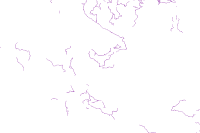

In [14]:
# # Upload as feature layer
# routes_sdf = GeoAccessor.from_geodataframe(routes, inplace=False, column_name='SHAPE')
# routes_fl = routes_sdf.spatial.to_featurelayer(title='State Park Trails',
#                                                          gis=gis,
#                                                          tags='Camping')

#Get feature layer
routes_fl = gis.content.get('a789dc2099c24e659c5829cab5beac2c')
routes_fl

In [15]:
trail_map = gis.map('California, US')
trail_map.add_layer(campgrounds_fl)
trail_map.add_layer(routes_fl)
trail_map

MapView(layout=Layout(height='400px', width='100%'))

#### Near River

<Item title:"CA Rivers" type:Feature Layer Collection owner:dsc170wi24_44>
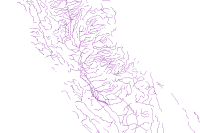

In [25]:
# river_sdf = GeoAccessor.from_geodataframe(river, inplace=False, column_name='SHAPE')
# river_fl = river_sdf.spatial.to_featurelayer(title='CA Rivers',
#                                                          gis=gis,
#                                                          tags='Camping')
river_fl = gis.content.get('d1dc945e8357493cb9219ed3491867fe')
river_fl

In [26]:
river_map = gis.map('California, US')
river_map.add_layer(river_fl)
river_map

MapView(layout=Layout(height='400px', width='100%'))

#### Mobile Service

In [32]:
mobile_sdf = GeoAccessor.from_geodataframe(mobile, inplace=False, column_name='SHAPE')
mobile_fl = mobile_sdf.spatial.to_featurelayer(title='Mobile Service',
                                                         gis=gis,
                                                         tags='Camping')
mobile_fl

<Item title:"Mobile Service" type:Feature Layer Collection owner:dsc170wi24_44>

11

#### Light Pollution

In [16]:
# Extent and clip
light_pollution_clip = extent_clip(light_pollution)

# Normalize map into 9 bins
light_pollution_n = remap(raster=light_pollution_clip,
                  input_ranges = [0.0, 9.0,
                                  9.0, 18.0,
                                  18.0, 27.0,
                                  27.0, 36.0,
                                  36.0, 45.0,
                                  45.0, 54.0,
                                  54.0, 63.0,
                                  63.0, 72.0,
                                  72.0, 81.0],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')

<Item title:"Light Pollution CA Feature Layer" type:Feature Layer Collection owner:dsc170wi24_44>
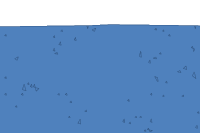

In [17]:
# Change imagery layer to feature layer
#light_fl = light_pollution_n.to_features()
# light_fl = gis.content.get('ce3a7029ab0346e5a0f6c2edbd507bf4')
light_fl = gis.content.get('afcf82caba7b45699f5a8e0fee321329')
light_fl

#### Air Pollution

In [18]:
# Extent and clip
air_clip = extent_clip(air_pollution)

# Normalize
air_n = remap(raster=air_clip,
                  input_ranges=[0,5,
                                5,6,
                                6,7,
                                7,8,
                                8,9,
                                9,11,
                                11,13,
                                13,584,
                                584,660],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')
air_n.compute_histograms(geometry=study_area_geom)

{'histograms': [{'size': 10,
   'min': -0.5,
   'max': 9.5,
   'counts': [0, 0, 3, 106, 280, 342, 579, 566, 581, 1470]}]}

<Item title:"Air Pollution CA Feature Layer" type:Feature Layer Collection owner:dsc170wi24_44>
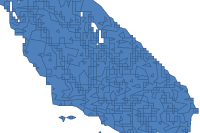

In [19]:
# Change to feature layer 
#air_fl = air_n.to_features()
#air_fl = gis.content.get('7ba57f788aa94960a0d99199a37b4891')

air_fl = gis.content.get('a5c244c6241344509635eda832609967')
air_fl

--------------------------------------------------------------------------------------

## Analysis

***TODO***

Provide a general outline of your analysis (in a markdown), and then document it step by step
as you code the solution. Please make sure that we can reproduce your analysis by running
your notebook. As before, a diagram describing your workflow would be helpful.

Please also reflect on how your actual analysis steps were different compared to your project
proposal - or state that you didn’t deviate from the initial plan.

(a combination of markdown and documented code cells)
(at least 500 words)

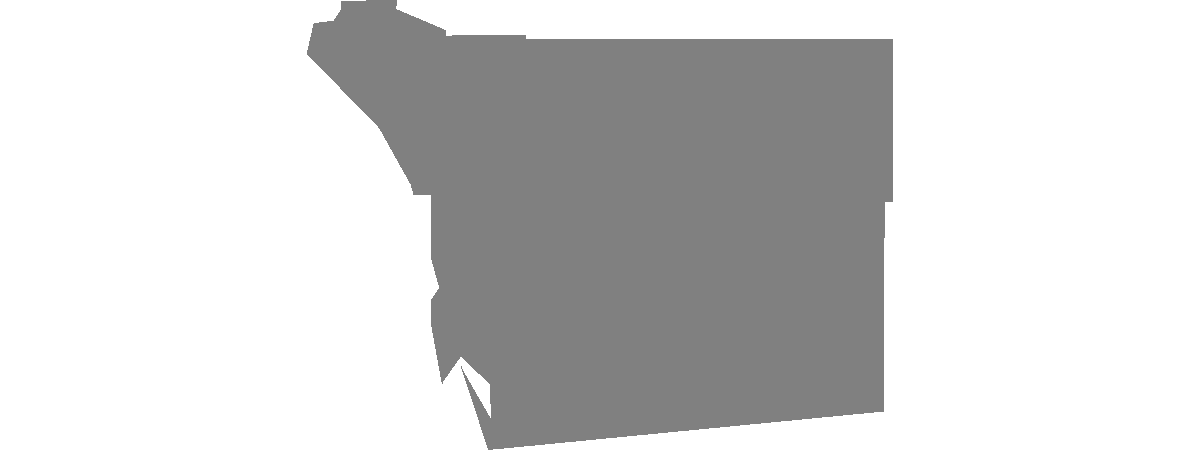

In [20]:
result = 0.5*light_pollution_n + 0.5*air_n
result

In [21]:
result_lyr = result.save("result_test_1234",gis=gis)

In [24]:
result_lyr.layers[0].properties

{
  "currentVersion": 11.2,
  "name": "result_test_1234",
  "serviceDescription": "",
  "description": "",
  "type": "ImageServer",
  "capabilities": "Image,Metadata,TilesOnly",
  "copyrightText": "",
  "serviceItemId": "3cf4dae09d6f4b06ae4174a943bdfd64",
  "meanPixelSize": 463.831191087825,
  "server": "eGSDp8lpKe5izqVc",
  "created": null,
  "modified": null,
  "status": "created",
  "access": "SECURE",
  "allowAnalysis": true,
  "allowCopy": false,
  "serviceSourceType": "esriImageServiceSourceTypeDataset",
  "spatialReference": {
    "wkid": 102100,
    "latestWkid": 3857
  },
  "extent": {
    "xmin": -13091171.149468705,
    "ymin": 3833698.449000089,
    "xmax": -12921872.764721649,
    "ymax": 3963571.18250468,
    "spatialReference": {
      "wkid": 102100,
      "latestWkid": 3857
    }
  },
  "initialExtent": {
    "xmin": -13091171.149468705,
    "ymin": 3833698.449000089,
    "xmax": -12921872.764721649,
    "ymax": 3963571.18250468,
    "spatialReference": {
      "wkid":

{'histograms': [{'size': 2, 'min': -0.5, 'max': 1.5, 'counts': [68367, 4606]}]}


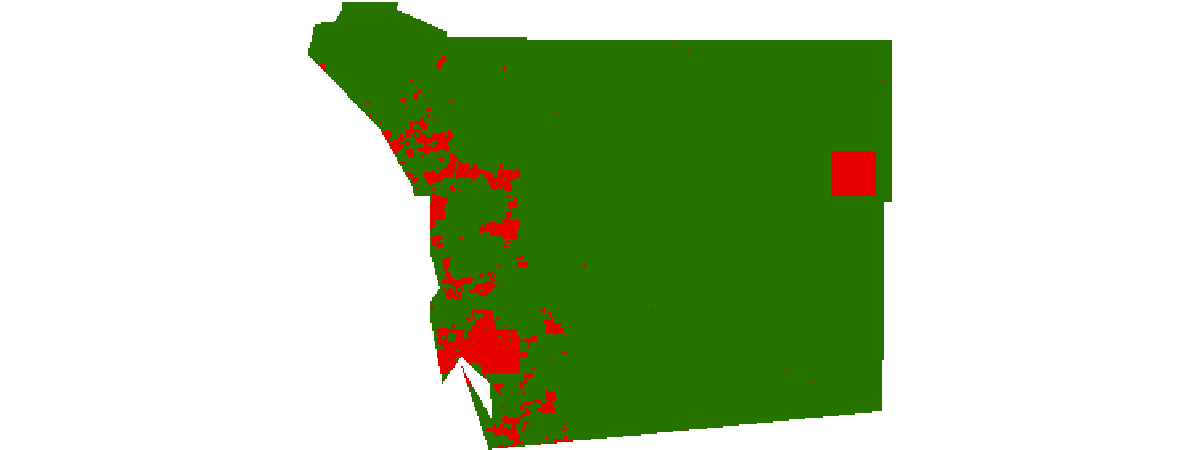

In [35]:
# not suitable (red) and suitable (green)
result2_b = remap(raster=result_lyr.layers[0],
                  input_ranges=[0,7, 7,141],
                  output_values=[1,0],  astype='U8')
print(result2_b.compute_histograms(geometry=study_area_geom))
clrmap2 =  [[1, 230, 0, 0], [0, 38, 115, 0]]

result2_c = colormap(result2_b, colormap=clrmap2)
result2_c

In [40]:
resultb_lyr = gis.content.get('bebd505291844055b36da1a181500fee')
resultb_lr = resultb_lyr.layers[0].to_features()
resutlb_lr

NameError: name 'resutlb_lr' is not defined

In [44]:
fl = gis.content.get('408cda385e164a958d916554edeac6c5')

In [97]:
#Developed campgrounds and restrooms
campgrounds_filtered = campgrounds_merged[campgrounds_merged['Showers'] == True]
campgrounds_filtered = campgrounds_filtered[campgrounds_filtered['Restrooms'] == True]
campgrounds_filtered.head()

,FID,Campground,GISID,TYPE,SUBTYPE,UNITNBR,DETAIL,UNITNAME,SHARE,GlobalID,...,geometry,Primitive,Developed,Horse,Restrooms,Showers,Flush_toilet,RV Parking,Vehicle Parking,Boat Parking
0,2074,Ritchey Creek Campground,GIS0006395,Developed Family Camp Area,None,240,Ritchey Creek Campground,Bothe-Napa Valley SP,None,{AC98673D-5387-4783-BB72-ED2987FA86AE},...,POINT (-13639496.195 4657348.494),False,True,False,True,True,False,False,True,False
1,2075,Bothe-Napa Valley Group Camp,GIS0006396,Developed Group Camp Area,None,240,Bothe-Napa Valley Group Camp,Bothe-Napa Valley SP,None,{196BF388-E240-49EC-A361-4330849D07E8},...,POINT (-13638520.925 4657386.784),False,True,False,True,True,False,False,True,False
2,2076,Brannan Island Group Camp,GIS0006398,Developed Group Camp Area,None,314,Brannan Island Group Camp,Brannan Island SRA,None,{D089D94A-75A3-409E-8B95-613D918F27C5},...,POINT (-13546051.275 4596380.365),False,True,False,True,True,False,False,True,True
3,2077,Walk-in Campsites,GIS0006399,Developed Family Camp Area,None,314,Walk-in Campsites,Brannan Island SRA,None,{C880DECC-2000-48C3-953E-B6AD4C29B49C},...,POINT (-13546394.584 4595659.599),False,True,False,True,True,False,False,True,True
4,2078,North Grove Campground,GIS0006400,Developed Family Camp Area,None,306,North Grove Campground,Calaveras Big Trees SP,None,{3C9F0EA0-DB71-479E-9486-C45DDB6C579E},...,POINT (-13392613.832 4618511.183),False,True,False,True,True,False,False,True,False


In [118]:
m = gis.map()
m.extent = study_area_extent        
m.legend=True
m.add_layer(fl,
 {"renderer":"ClassedColorRenderer",
 "field_name":"gridcode",
 "opacity":0.7,
 })
m

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [119]:
m.add_layer(camps_fl)

In [109]:
camps_filtered_sdf = GeoAccessor.from_geodataframe(campgrounds_filtered, inplace=False, column_name='SHAPE')
camps_fl = camps_filtered_sdf.spatial.to_featurelayer(title='Campgrounds Filtered',
                                                         gis=gis,
                                                         tags='Camping')

In [111]:
desired_polygon = campgrounds_filtered[campgrounds_filtered['attribute_column'] == desired_value].unary_union

AttributeError: 'Item' object has no attribute 'intersect'

--------------------------------------------------------------------------------------

## Results

***TODO***

Describe what you found, and why it is important; illustrate the findings with maps/charts
reflecting your results.

(a combination of markdown and documented code cells)

(200 words)

## Discussion

The discussion should include the following parts:
1) Discuss your findings with respect to the literature sources in section 3. What do the
results mean in the context of what is already known? What is new? Does it validate
what was found in literature? How do your results improve our understanding of the
problem?

2) Of particular importance is a discussion of any trade-offs and decision points that you
had to consider. This may include a discussion of any performance issues, width of
buffers you applied, projections you chose, spatial operations you used, machine
learning techniques, and other issues we discussed in class.
(this can be done as a markdown, at least 200 words)

## Conclusions and Future Work

Did you manage to completely answer your initial research question? If not, what additional
data and additional analysis steps can you think of? Can your approach be extended to other
areas or topics, and use additional datasets? How do you expect the results to be used and by
whom?

(a markdown cell, at least 200 words)
